# Variational Autoencoder: _LeNet-5_ CNN with PyTorch and MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.9.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# Hyper-parameters-
num_epochs = 50
batch_size = 32
learning_rate = 0.001

### MNIST data pre-processing:

In [6]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [7]:
path_to_data = "C:\\Users\\Arjun\\Desktop\\VAE_resources\\"
# path_to_data = "C:\\Users\\arjun\Downloads\\"

In [8]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        # root = './data', train = True,
        root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        # root = './data', train = False,
        root = path_to_data + "data", train = False,
        transform = transforms_apply
        )

C:\Users\Arjun\anaconda3\envs\pytorch-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 1875 and test_loader: 313


In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 1875 & len(test_loader) = 313


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(1875.0, 312.5)

In [13]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([32, 1, 28, 28]) & labels.shape: torch.Size([32])


In [14]:
# Reshape input so that it can be fed into LeNet-300-100 architecture model-
images.reshape(-1, 28 * 28 * 1).shape

torch.Size([32, 784])

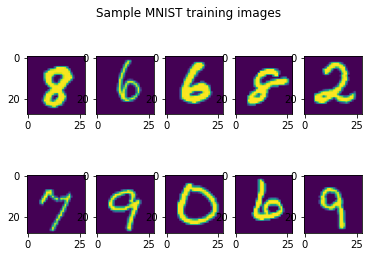

In [15]:
# Visualize 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0])    # 0 to access first channel
    # plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

### Define _Variational Autoencoder_ architecture:

In [14]:
class LeNet_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Encoder, self).__init__()
        
        self.latent_space = latent_space
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, stride = 2,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.dense = nn.Linear(
            in_features = 64, out_features = 30,
            bias = True
        )
        self.dense2 = nn.Linear(
            in_features = 30, out_features = 10,
            bias = True
        )
        self.encoder_output = nn.Linear(
            in_features = 10, out_features = self.latent_space,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # print(f"before flatten, x.shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dense(x))
        x = F.leaky_relu(self.dense2(x))
        x = F.leaky_relu(self.encoder_output(x))
        return x
        


In [15]:
class LeNet_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Decoder, self).__init__()
        
        self.latent_space = latent_space
        self.dense_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 10,
            bias = True
        )
        self.dense_layer2 = nn.Linear(
            in_features = 10, out_features = 30,
            bias = True
        )
        self.dense_layer3 = nn.Linear(
            in_features = 30, out_features = 64,
            bias = True
        )
        
        self.conv_tran_layer1 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer2 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer3 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 6,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.op_conv_tran_layer = nn.ConvTranspose2d(
            in_channels = 6, out_channels = 1,
            kernel_size = 2, stride = 2,
            padding = 0
        )

        
        
    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        x = F.leaky_relu(self.dense_layer3(x))
        x = x.view(-1, 16, 2, 2)
        x = F.leaky_relu(self.conv_tran_layer1(x))
        x = F.leaky_relu(self.conv_tran_layer2(x))
        x = F.leaky_relu(self.conv_tran_layer3(x))
        x = self.op_conv_tran_layer(x)
        return x
 

In [18]:
# encoder = LeNet_Encoder(latent_space = 3)

In [ ]:
# encoded_images = encoder(images)

In [ ]:
# encoded_images.shape, images.shape

In [19]:
# decoder = LeNet_Decoder(latent_space = 3)

In [21]:
# decoded_images = decoder(encoded_images)

In [20]:
# decoded_images.shape, images.shape

In [ ]:
# del encoded_images, decoded_images, encoder, decoder

In [17]:
class VAE_Conv(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Conv, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'hidden2mu' & 'hidden2log' to convert the bottleneck into the μ and σ vectors-
        self.hidden2mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.hidden2log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.decoder = LeNet_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        
        return recon_data, mu, log_var
        

In [18]:
# Initialize a VAE objetc-
model = VAE_Conv(latent_space = 3).to(device)

In [19]:
print(model)

VAE_Conv(
  (encoder): LeNet_Encoder(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (dense): Linear(in_features=64, out_features=30, bias=True)
    (dense2): Linear(in_features=30, out_features=10, bias=True)
    (encoder_output): Linear(in_features=10, out_features=3, bias=True)
  )
  (hidden2mu): Linear(in_features=3, out_features=3, bias=True)
  (hidden2log_var): Linear(in_features=3, out_features=3, bias=True)
  (decoder): LeNet_Decoder(
    (dense_layer1): Linear(in_features=3, out_features=10, bias=True)
    (dense_layer2): Linear(in_features=10, out_features=30, bias=True)
    (dense_layer3): Linear(in_features=30, out_features=64, bias=True)
    (conv_tran_layer1): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv_tran_layer2): ConvTranspos

In [20]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([6, 1, 3, 3]) has 54 parameters
layer.shape = torch.Size([6]) has 6 parameters
layer.shape = torch.Size([16, 6, 5, 5]) has 2400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([30, 64]) has 1920 parameters
layer.shape = torch.Size([30]) has 30 parameters
layer.shape = torch.Size([10, 30]) has 300 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([3, 10]) has 30 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([10, 3]) has 30 parameters
layer.shape = t

In [21]:
print(f"Total number of parameters in VAE Dense model = {tot_params}")

Total number of parameters in VAE Dense model = 35242


### Initial _variance_ - Sanity check:

_Before_ training the VAE neural network model, there should be some initial variance.

In [22]:
for x in model.hidden2mu.parameters():
    print(x.shape, x.nelement())

torch.Size([3, 3]) 9
torch.Size([3]) 3


In [23]:
log_var_wts = model.hidden2log_var.weight
mu_wts = model.hidden2mu.weight

In [24]:
mu_wts = mu_wts.detach().cpu().numpy()
log_var_wts = log_var_wts.detach().cpu().numpy()

In [25]:
mu_wts.shape, log_var_wts.shape

((3, 3), (3, 3))

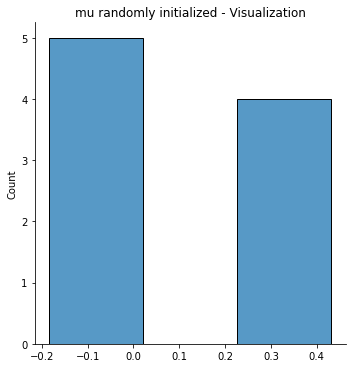

In [26]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu randomly initialized - Visualization")
plt.show()

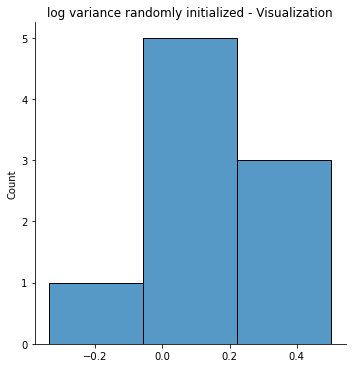

In [27]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance randomly initialized - Visualization")
plt.show()

In [28]:
del mu_wts, log_var_wts

In [29]:
images = images.to(device)

In [30]:
images.shape

torch.Size([32, 1, 28, 28])

In [31]:
images.min(), images.max()

(tensor(-0.4242), tensor(2.8215))

In [32]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [33]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 3]), torch.Size([32, 3]))

In [34]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

# tanh activation function-
# (array(-0.05745536, dtype=float32), array(0.23623492, dtype=float32))

# sigmoid activation function-
# (array(0.43894547, dtype=float32), array(0.5463941, dtype=float32))

(array(0.444928, dtype=float32), array(0.46043667, dtype=float32))

In [35]:
del recon_images, mu, log_var

In [22]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [23]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [24]:
# Reconstruction loss-
# criterion = nn.BCELoss(reduction = 'sum')
# BCE cost function can only be used with sigmoid activation function in decoder's last
# layer, because log function's domain is all real positive numbers!

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch
# documentations, then this is specifically for the case of autoencoders only.

# Also, MSE loss could also be used-
criterion = nn.MSELoss(reduction = 'sum')
# MSE cost function can be used with either sigmoid or tanh activation function
# in decoder's last layer.

In [25]:
def total_loss(reconstruction_loss, mu, log_var, alpha = 1):
    '''
    Function to add reconstruction loss and KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    4. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss.
    '''
    
    # reconstruction_loss = F.binary_cross_entropy_with_logits(input, target)
    
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # final_loss = reconstruction_loss + KLD
    final_loss = (reconstruction_loss * alpha) + KLD
    
    return final_loss


In [26]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    running_loss = 0.0
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        recon_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(recon_loss, mu, logvar, alpha)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
    train_loss = running_loss / len(dataloader.dataset)
    
    return train_loss, mu, logvar


In [27]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test_dataset) / dataloader.batch_size)):
          
            # Ignore labels-
            data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            reconstruction, mu, logvar = model(data)
            
            # Compute reconstruction loss-
            recon_loss = criterion(reconstruction, data)
            
            # Compute total loss-
            loss = total_loss(recon_loss, mu, logvar, alpha)
            
            # Update loss-
            running_loss += loss.item()
            
    val_loss = running_loss / len(dataloader.dataset)
    
    return val_loss, mu, logvar


In [ ]:
# alpha = 1

In [ ]:
# Sanity check-
'''
train_epoch_loss, mu_train, logvar_train = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = alpha
    )
'''

In [ ]:
# Sanity check-
'''
val_epoch_loss, mu_val, logvar_val = validate_one_epoch(
    model = model, dataloader = test_loader,
    alpha = alpha
    )
'''

In [ ]:
# print(f"train loss = {train_loss:.4f} & test loss = {test_loss:.4f}")

### Train VAE model with _early stopping criterion_:

In [28]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1

In [29]:
# Python dict to contain training metrics-
train_history = {}

In [30]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 50 epochs


In [33]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000
loc_patience = 0

In [32]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [34]:
for epoch in range(1, num_epochs + 1):
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
        
    # Train model for 1 epoch-
    train_epoch_loss, mu_train, logvar_train = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )
    
    # Get validation metrics-
    val_epoch_loss, mu_val, logvar_val = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )
    
    # Retrieve model performance metrics-
    logvar_train = logvar_train.mean().detach().cpu().numpy()
    logvar_val = logvar_val.mean().detach().cpu().numpy()
    mu_train = mu_train.mean().detach().cpu().numpy()
    mu_val = mu_val.mean().detach().cpu().numpy()

    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_epoch_loss,
        'val_loss': val_epoch_loss,
        'train_logvar': logvar_train,
        'val_logvar': logvar_val,
        'train_mu': mu_train,
        'val_mu': mu_val
    }

    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f},"
    f"test loss = {val_epoch_loss:.4f}, train_logvar = {logvar_train:.6f}"
    f", train_mu = {mu_train:.6f}, val_logvar = {logvar_val:.6f} &"
    f" val_mu = {mu_val:.6f}")
    
    
    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_epoch_loss < best_val_loss) and \
    (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_epoch_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_epoch_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet5_MNIST_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
        
    

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:01<00:00, 30.72it/s]
313it [00:04, 67.02it/s]                                                                                               


Epoch = 1; train loss = 613.5191,test loss = 584.5461, train_logvar = -1.985159, train_mu = -0.052829, val_logvar = -1.907856 & val_mu = -0.064855
Saving model with lowest val_loss = 584.5461



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:55<00:00, 33.55it/s]
313it [00:04, 68.15it/s]                                                                                               


Epoch = 2; train loss = 574.5083,test loss = 560.8862, train_logvar = -5.106112, train_mu = 0.450328, val_logvar = -3.919033 & val_mu = 0.189184
Saving model with lowest val_loss = 560.8862



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:56<00:00, 33.46it/s]
313it [00:04, 70.58it/s]                                                                                               


Epoch = 3; train loss = 542.8471,test loss = 538.3238, train_logvar = -4.355397, train_mu = 0.227233, val_logvar = -4.242508 & val_mu = 0.143113
Saving model with lowest val_loss = 538.3238



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:52<00:00, 35.77it/s]
313it [00:04, 77.36it/s]                                                                                               


Epoch = 4; train loss = 528.2176,test loss = 529.1236, train_logvar = -4.122744, train_mu = 0.039334, val_logvar = -4.156411 & val_mu = -0.012543
Saving model with lowest val_loss = 529.1236



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:57<00:00, 32.69it/s]
313it [00:05, 56.84it/s]                                                                                               


Epoch = 5; train loss = 521.9878,test loss = 525.0874, train_logvar = -4.575462, train_mu = 0.051818, val_logvar = -4.276489 & val_mu = -0.036700
Saving model with lowest val_loss = 525.0874



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:58<00:00, 32.26it/s]
313it [00:05, 60.57it/s]                                                                                               


Epoch = 6; train loss = 517.8629,test loss = 520.4982, train_logvar = -4.654249, train_mu = 0.014441, val_logvar = -4.293824 & val_mu = -0.035627
Saving model with lowest val_loss = 520.4982



100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:58<00:00, 32.21it/s]
313it [00:04, 71.52it/s]                                                                                               


Epoch = 7; train loss = 22762245551.5273,test loss = 955.7345, train_logvar = -9.392807, train_mu = 0.167750, val_logvar = -8.033805 & val_mu = -0.054466


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:56<00:00, 33.31it/s]
313it [00:04, 76.56it/s]                                                                                               


Epoch = 8; train loss = 32951.8717,test loss = 813.9869, train_logvar = -8.310115, train_mu = -0.027313, val_logvar = -8.063334 & val_mu = -0.025932


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:55<00:00, 33.87it/s]
313it [00:05, 59.63it/s]                                                                                               

Epoch = 9; train loss = 19033.4180,test loss = 724.7307, train_logvar = -9.739213, train_mu = 0.145077, val_logvar = -8.056046 & val_mu = -0.020834

'EarlyStopping' called!



In [48]:
# Save trained VAE model's weights-
# torch.save(model.state_dict(), 'VAE_LeNet5_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 5).to(device)
# loaded_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [35]:

import pickle

# Save training history as pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

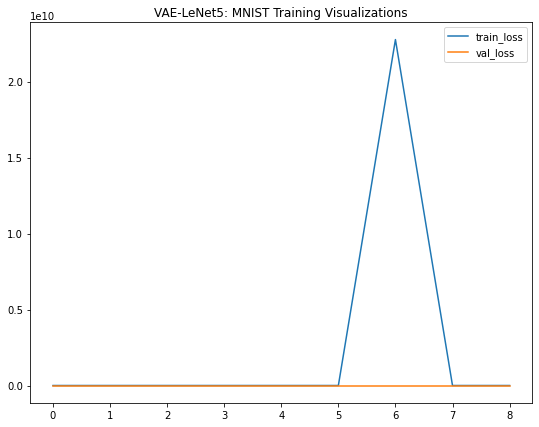

In [36]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_loss'] for x in train_history.keys()], label = 'train_loss')
plt.plot([train_history[x]['val_loss'] for x in train_history.keys()], label = 'val_loss')
plt.legend(loc = 'best')
plt.title("VAE-LeNet5: MNIST Training Visualizations")
plt.show()

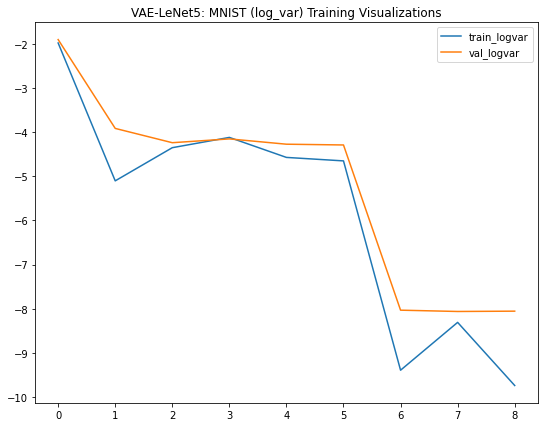

In [37]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_logvar'] for x in train_history.keys()], label = 'train_logvar')
plt.plot([train_history[x]['val_logvar'] for x in train_history.keys()], label = 'val_logvar')
plt.legend(loc = 'best')
plt.title("VAE-LeNet5: MNIST (log_var) Training Visualizations")
plt.show()

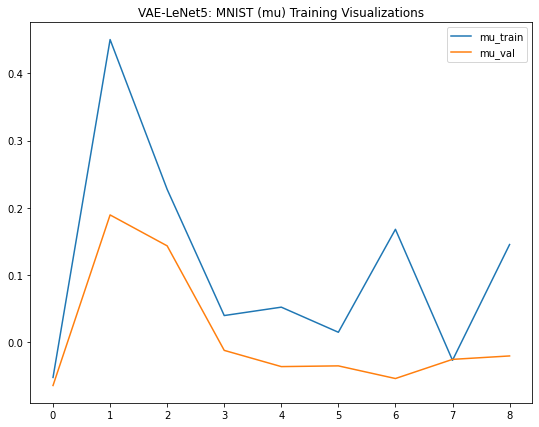

In [38]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_mu'] for x in train_history.keys()], label = 'mu_train')
plt.plot([train_history[x]['val_mu'] for x in train_history.keys()], label = 'mu_val')
plt.legend(loc = 'best')
plt.title("VAE-LeNet5: MNIST (mu) Training Visualizations")
plt.show()

### Reconstruct/Generate images using _trained_ VAE model:

In [39]:
images = images.to(device)

In [40]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [41]:
recon_images = recon_images.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()
log_var = log_var.cpu().detach().numpy()

In [42]:
recon_images.shape, mu.shape, log_var.shape

((32, 1, 28, 28), (32, 3), (32, 3))

In [43]:
# Unnormalize images-
recon_images = recon_images / 2 + 0.5
# recon_images = np.transpose(recon_images, (0, 2, 3, 1))

In [44]:
recon_images.shape

(32, 1, 28, 28)

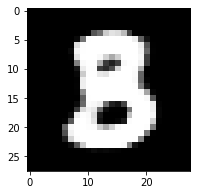

In [46]:
plt.figure(figsize = (5, 3))
plt.imshow(recon_images[0][0], cmap = 'gray')
plt.show()


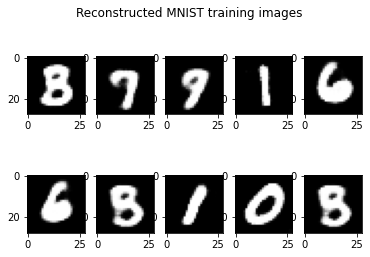

In [47]:
# Visualize 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()


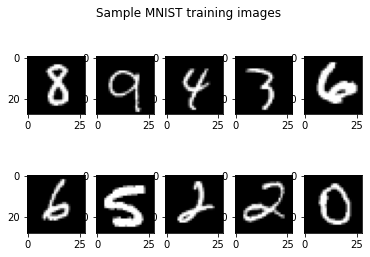

In [48]:
# Print 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0].cpu(), cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

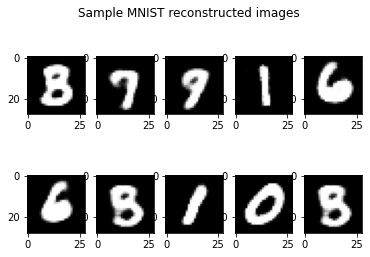

In [49]:
# Print 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

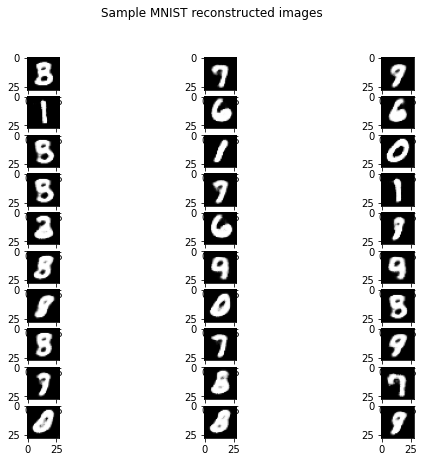

In [50]:
# Print 30 images from reconstructions-
plt.figure(figsize = (9, 7))

for i in range(30):
    plt.subplot(10, 3, i + 1)    # 10 rows & 3 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

In [ ]:
for images, _ in train_loader:
    images = images.to(device)
    
    recon_images_n, mu_n, log_var_n = model(images)
    recon_images_n = recon_images_n.detach().cpu().numpy()
    mu_n = mu_n.detach().cpu().numpy()
    log_var_n = log_var_n.detach().cpu().numpy()

    recon_images = np.concatenate((recon_images, recon_images_n), axis = 0)
    mu = np.concatenate((mu, mu_n), axis = 0)
    log_var = np.concatenate((log_var, log_var_n), axis = 0)
    print(f"recon_images.shape: {recon_images.shape}, mu.shape: {mu.shape}"
         f" & log_var.shape: {log_var.shape}")

In [ ]:
# Get a batch of training data & it's corresponding labels-
images, labels = next(iter(train_loader))
images = images.to(device)

In [ ]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [ ]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [51]:
recon_images.shape, mu.shape, log_var.shape

((32, 1, 28, 28), (32, 3), (32, 3))

In [ ]:
# !pip install umap-learn

In [ ]:
# import umap
# import umap.umap_ as umap

In [ ]:
'''
reducer = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)
'''

In [52]:
# embedding_mu = reducer.fit_transform(mu)
# embedding_mu.shape

In [ ]:
'''
reducer_logvar = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)
'''

In [ ]:
# embedding_logvar = reducer.fit_transform(log_var)
# embedding_logvar.shape

In [54]:
import plotly
import plotly.express as px

In [ ]:
# Visualize latent space for 'mean'-
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
'''
# Visualize latent space for 'mean'-
fig = px.scatter_3d(
    x = embedding_mu[:, 0], y = embedding_mu[:, 1],
    z = embedding_mu[:, 2],
    # color = y_train
    )
fig.show()
'''

In [ ]:
# Visualize latent space for 'log variance'-
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
'''
# Visualize latent space for 'log variance'-
fig = px.scatter_3d(
    x = embedding_logvar[:, 0], y = embedding_logvar[:, 1],
    z = embedding_logvar[:, 2],
    # color = y_train
    )
fig.show()
'''